# Entanglement: gather and plot results

In [35]:
# Plotting libraries and setting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import seaborn as sns
cmap = sns.color_palette('deep', as_cmap=True)

# Useful libraries
import numpy as np
import json
from tqdm import tqdm
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Simulation experiment
from qcircha.utils import gather_data, list_data
from qcircha.circuit_selector import pick_circuit
from qcircha.experiments import compute_bond_entanglement

# Path of the simulation data
data_path = "./data/ent_scaling/"
list_data(path=data_path)

['2022-02-28_16-50-16_898',
 '2022-02-28_17-40-06_28',
 '2022-02-28_17-05-58_812',
 '2022-03-09_11-11-46_568',
 '2022-03-09_11-12-57_552',
 '2022-03-09_11-15-26_377',
 '2022-02-25_18-43-03_427',
 '2022-03-01_12-50-54_684',
 '2022-02-25_18-05-23_651',
 '2022-02-28_16-44-58_330',
 '2022-02-28_16-42-55_464',
 '2022-02-28_18-01-34_505',
 '2022-02-26_18-45-40_923',
 '2022-03-01_16-53-11_400',
 '2022-02-28_17-50-17_956',
 '2022-02-26_18-43-39_545',
 '2022-02-28_18-07-59_681',
 '2022-03-10_14-20-39_713',
 '2022-02-25_18-22-50_651',
 '2022-02-28_17-45-16_517',
 '2022-03-09_10-52-33_310',
 '2022-03-10_14-19-44_213',
 '2022-03-09_10-51-15_895',
 '2022-03-01_17-04-41_29',
 '2022-03-01_18-29-41_431',
 '2022-02-26_18-47-34_697',
 '2022-02-26_19-30-20_890',
 '2022-03-01_12-28-13_706',
 '2022-02-28_14-29-13_329',
 '2022-02-28_17-02-58_278',
 '2022-02-26_19-25-46_58',
 '2022-02-26_19-23-34_315',
 '2022-02-28_14-22-37_117',
 '2022-03-09_10-54-08_19',
 '2022-02-28_17-58-55_935',
 '2022-03-01_12-35-51_89

## Entanglement scaling

##### 1) Single plot

Select a results from existing simulation run, given specifics of the QNN: _feature map_, _variational ansatz_, _entanglement topology_, ... . Inspect a `.json` file in the data folder to check available keys. 

In [3]:
# Provide keys in the json file, and corresponding desired value
data_runs = gather_data(key   = ['alternate', 'fmap'        , 'var_entanglement'],
                        value=[True,          'TwoLocal', 'linear'],
                        path=data_path)

# Select a run from those satisfying (key, values) requirements above
idx_run = 0
run = data_runs[idx_run]
print(f"{len(data_runs)} runs available. Selecting run: {run}")

# Load data
ent_data = np.load(data_path + run + ".npy", allow_pickle=True)
with open(data_path + run + '.json') as file:
    ent_metadata = json.load(file)
pp.pprint(ent_metadata)

2 runs available. Selecting run: 2022-02-28_16-42-55_464
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal',
    'fmap_entanglement': 'linear',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'linear'}


A single element in the `ent_data` list, be it `data = ent_data[0]`, contains the results for a specific number of qubits, with varying repetitions. It is organized as follows:
1. `data[0]`: contains total entanglement (1d-array of dimension num_reps)
2. `data[1]`: standard deviation of total entanglement (not significant as results are consistent)
3. `data[3]`: expected total entanglement if Haar.

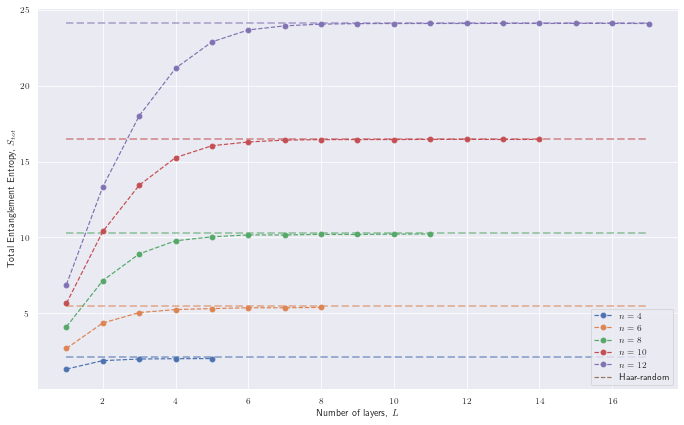

In [4]:
fig = plt.figure(figsize=(9.6, 6))

title = f"{ent_metadata['fmap']}_{ent_metadata['var_ansatz']}"
plt.ylabel("Total Entanglement Entropy, $S_{tot}$")
plt.xlabel("Number of layers, $L$")

plt.ylim(0, max(ent_data[-1, 0])+1)
plt.yticks(range(5, int(max(ent_data[-1, 0])+5), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
for idx, data in enumerate(ent_data):
    plt.hlines(data[2], 1, len(ent_data[-1, 0]),
               ls="--", color=cmap[idx], lw=2, alpha=0.5)
    plt.plot(range(1, len(data[0])+1), data[0], ls="--",
             marker="o", c=cmap[idx], label=f"$n = {n_qubits[idx]}$")

plt.plot([], [], ls='--', color=cmap[idx+1], label="Haar-random")

plt.legend(loc=4)
plt.tight_layout()
#plt.savefig("data/Imgs/" + run + ".pdf", format="pdf")

##### 2) Entanglement map comparison: linear vs. circular vs. a2a

Selecting data

In [5]:
ent_datas = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap'                 , 'var_ansatz', 'var_entanglement'],
                            value=[True     , 'TwoLocal_parametricRz', 'TwoLocal'  , ent_map], 
                            path=data_path)
    
    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    pp.pprint(ent_metadata)

1 runs available. Selecting run: 2022-03-01_12-28-13_706
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'linear',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'linear'}
1 runs available. Selecting run: 2022-03-01_12-35-51_898
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'circular',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'circular'}
1 runs available. Selecting run: 2022-03-01_12-50-54_684
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'full',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'full'}


Plot data

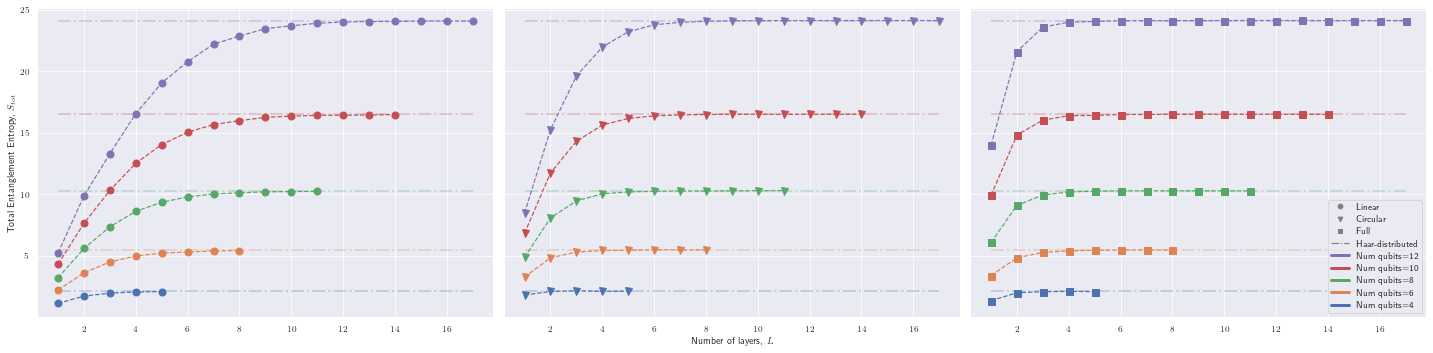

In [6]:
def do_plot(dataplot, ax=None):
    """Custom plot style"""
    # Run trough number of qubits
    for idx, data in enumerate(dataplot):
        # Haar limit
        ax.hlines(data[2], 1, len(_ent[-1, 0]), ls="-.", color=cmap[idx], lw=2, alpha=0.25)
        # Simulation results
        ax.errorbar(range(1, len(data[0])+1), data[0], yerr=0*data[1], ls="--", marker=markers[jdx], c=cmap[idx], markersize=7, alpha=1)
    return 


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True, sharex=True)

title = f"{ent_metadata['fmap']}_{ent_metadata['var_ansatz']}"

# SET Y-AXIS
plt.ylim(0, max(ent_data[-1, 0])+1)
plt.yticks(range(5, int(max(ent_data[-1, 0])+5), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
markers = ['o', 'v', 's']

# PLOT ENTANGLEMENT DATA
# Run through entanglement topology
for jdx, (ax, _ent) in enumerate(zip(axs, ent_datas.values())): 
    do_plot(_ent, ax = ax)

# MARKERS LEGEND
axs[2].plot([], [], ls=" ", marker=markers[0], c='gray', label="Linear")
axs[2].plot([], [], ls=" ", marker=markers[1], c='gray', label="Circular")
axs[2].plot([], [], ls=" ", marker=markers[2], c='gray', label="Full")

# LINE LEGEND
axs[2].plot([], [], ls='-.', color='grey', label="Haar-distributed")
for i in list(range(5))[::-1]:
    axs[2].plot([], [], lw=3, c=cmap[i], label=f"Num qubits={n_qubits[i]}")

# SET LABEL NAMES
axs[0].set_ylabel("Total Entanglement Entropy, $S_{tot}$")
axs[1].set_xlabel("Number of layers, $L$")

# PLOT LEGEND
axs[2].legend(loc=4)

plt.tight_layout()
#plt.savefig("data/Imgs/" + 'TwoLocalParam2q_TwoLocal' + ".pdf", format="pdf")


##### 3) Full comparison: architecture vs. entanglement (as in manuscript)

Selecting data

In [36]:
# SELECTING FIRST QNN ARCHITECTURE
ent_datas_QNN = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'ZZFeatureMap', 'TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING SECOND QNN ARCHITECTURE
print(" ")

ent_datas_QNN1 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'TwoLocal','TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN1[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING THIRD QNN ARCHITECTURE
print(" ")

ent_datas_QNN2 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'TwoLocal_parametricRz','TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN2[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING FOURTH QNN ARCHITECTURE
print(" ")

ent_datas_QNN3 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'circuit1', 'TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN3[ent_map] = np.load(
        data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

data_to_plot = [ent_datas_QNN, ent_datas_QNN1, ent_datas_QNN2, ent_datas_QNN3]

2 runs available. Selecting run: 2022-02-25_18-43-03_427
2 runs available. Selecting run: 2022-02-28_17-05-58_812
2 runs available. Selecting run: 2022-02-25_18-22-50_651
 
2 runs available. Selecting run: 2022-02-28_16-42-55_464
2 runs available. Selecting run: 2022-02-28_16-44-58_330
2 runs available. Selecting run: 2022-02-28_16-50-16_898
 
1 runs available. Selecting run: 2022-03-01_12-28-13_706
1 runs available. Selecting run: 2022-03-01_12-35-51_898
1 runs available. Selecting run: 2022-03-01_12-50-54_684
 
2 runs available. Selecting run: 2022-03-09_10-51-15_895
2 runs available. Selecting run: 2022-02-26_18-45-40_923
2 runs available. Selecting run: 2022-02-26_18-43-39_545


Plot

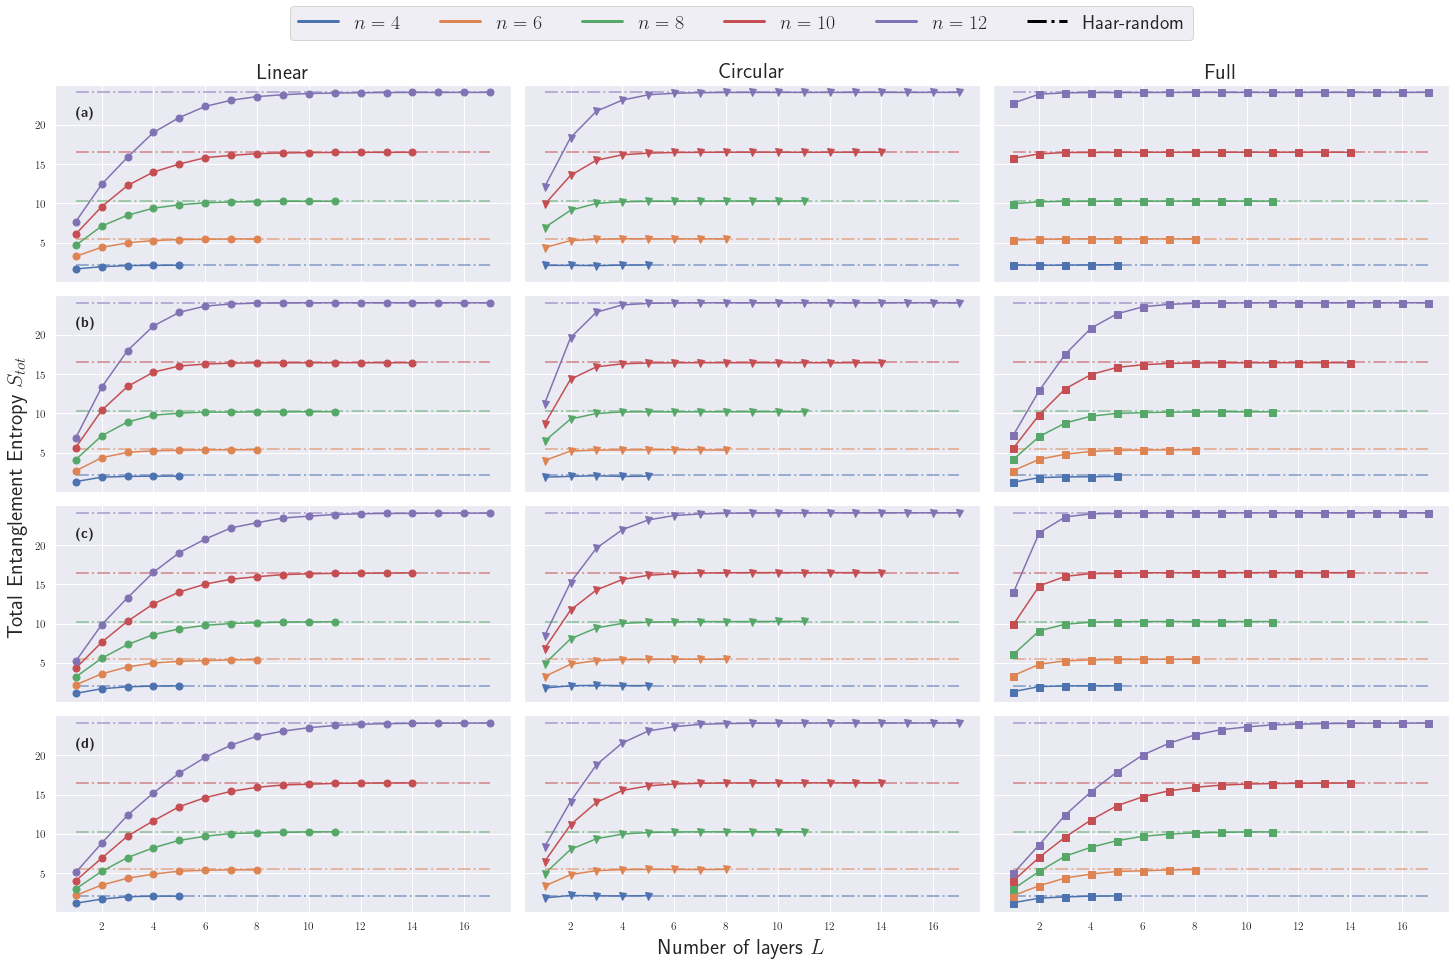

In [93]:
def do_plot(dataplot, ax=None):
    """Custom plot style"""
    # Run trough number of qubits
    alphas = np.ones(len(dataplot)) #np.linspace(0.4, 1, len(dataplot))
    for idx, data in enumerate(dataplot):
        # Haar limit
        ax.hlines(data[2], 1, len(_ent[-1, 0]), ls="-.", color=cmap[idx], lw=2, alpha=0.5)
        # Simulation results
        ax.errorbar(range(1, len(data[0])+1), data[0], yerr=0*data[1], alpha = alphas[idx], ls="-", marker=markers[jdx], c=cmap[idx], markersize=7)
    return

fig, axs = plt.subplots(len(data_to_plot), 3, figsize=(20, 12.42), sharey=True, sharex=True)

# SET Y-AXIS
plt.ylim(0, max(ent_datas_QNN['linear'][-1, 0])+1)
plt.yticks(range(5, int(max(ent_datas_QNN['linear'][-1, 0])+0), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
markers = ['o', 'v', 's']

# PLOT ENTANGLEMENT DATA
for kdx, ent_d in enumerate(data_to_plot): # Run through architectures
    this_ax = axs[kdx]
    for jdx, (ax, _ent) in enumerate(zip(this_ax, ent_d.values())): # Run through entanglement topology
        do_plot(_ent, ax = ax)

# ADD PANEL LETTER
for idx, l in enumerate(['a','b','c','d','f'][:len(data_to_plot)]):
    axs[idx,0].text(1., 21., r"$\textbf{("+l+r")}$", fontsize = 14)

# ENTANGLING TOPOLOGY
axs[0, 0].set_title("Linear", fontsize=22)
axs[0, 1].set_title("Circular", fontsize=22)
axs[0, 2].set_title("Full", fontsize=22)

# LINE LEGEND
axs[-1, -1].plot([], [], ls='-.', color='grey', label="Haar-random")
for i in list(range(5))[::-1]:
    axs[-1, -1].plot([], [], lw=3, c=cmap[i], label=f"$n={n_qubits[i]}$")

# SET LABEL NAMES
fig.text(0.5, -0.01, 'Number of layers $L$', ha='center', fontsize=22)
fig.text(-0.01, 0.5, 'Total Entanglement Entropy $S_{tot}$', va='center', rotation='vertical', fontsize=22)

# PLOT LEGEND
axs[-1,-1].legend(loc=4, fontsize=16)

# PLOT LEGEND 
#axs[-1,-1].legend(loc=4)\n",
# Shrink current axis's height by 10% on the bottom\n",
#handles, labels = axs[-1, -1].get_legend_handles_labels()
#handles, labels = handles[::-1], labels[::-1]
#handles[-1].set_lw(3)
#handles[-1].set_color('black')
#fig.legend(handles, labels, loc='lower center', fontsize=20, ncol=6, bbox_to_anchor=(0.5, 1.))
#
#left  = 0.06  # the left side of the subplots of the figure\n",
#right = 0.9   # the right side of the subplots of the figure\n",
#bottom = 0.13   # the bottom of the subplots of the figure\n",
#top = 0.9      # the top of the subplots of the figure\n",
#wspace = 0.1  # the amount of width reserved for blank space between subplots\n",
#hspace = 0.05   # the amount of height reserved for white space between subplots\n",
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.tight_layout()
#plt.savefig('complete_comparison_final3' + ".pdf", format="pdf", bbox_inches="tight")


## Entanglement distribution across bonds

##### 1) Single architecture plot

Generating data

In [93]:
# Quantum Cirucit structure
num_qubits = 8
alternate = True

# Choose simulation backend
#backend = 'MPS'
backend = 'Aer'

% % capture
feature_map = 'Circuit1'
var_ansatz = 'TwoLocal'
ent_list, max_ent = compute_bond_entanglement(num_qubits,
                                              feature_map=feature_map, var_ansatz=var_ansatz,
                                              alternate=True, backend=backend,
                                              plot=False, max_bond_dim=None)

UsageError: Line magic function `%` not found.


Plot data

NameError: name 'ent_list' is not defined

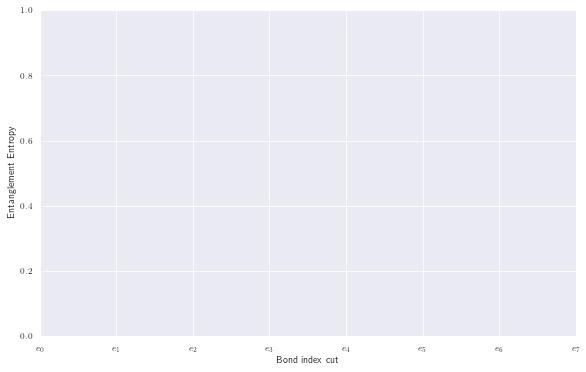

In [94]:
fig = plt.figure(figsize=(9.6, 6))

labels = [f'$e_{i}$' for i in range(num_qubits)]
plt.xticks(range(num_qubits), labels=labels)
plt.ylabel("Entanglement Entropy")
plt.xlabel("Bond index cut")

alphas = np.linspace(0.5, 1, len(ent_list[:num_qubits-1]))

for idx, data in enumerate(ent_list[:num_qubits-1]):
    plt.errorbar(range(1, num_qubits), data[0], yerr=0*data[1], color = cmap[idx], alpha = alphas[idx], label=f"$L={idx+1}$", marker='o')

plt.plot(range(1, num_qubits), max_ent, ls='--', color=cmap[-3], lw=2, alpha=1, marker='d', label="Maximally Entangled")
plt.plot(range(1, num_qubits), ent_list[0, 2], ls='-.', color=cmap[-2], lw=2, alpha=1, marker = 'v', label="Haar-random")

plt.legend(loc = 1)

plt.tight_layout()
#plt.savefig(f"data/Imgs/bond_plots/{feature_map}_{var_ansatz}_linear_2.pdf", format="pdf")

##### 2) Comparison of multiple structures (as in manuscript)

Generating data

In [38]:
%%capture

# Quantum Cirucit structure
num_qubits = 8
alternate = True

# Choose simulation backend
#backend = 'MPS'
backend = 'Aer'

feature_map = 'ZZFeatureMap'
var_ansatz = 'TwoLocal'
ent_list, max_ent = compute_bond_entanglement(num_qubits,
                                              feature_map=feature_map, var_ansatz=var_ansatz,
                                              alternate=True, backend=backend,
                                              plot=False, max_bond_dim=None)
  
print("Done! Doing second sctructure...")

feature_map1 = 'ZZFeatureMap_ring'
var_ansatz1 = 'TwoLocal_ring'
ent_list_c1, max_ent_c1 = compute_bond_entanglement(num_qubits,
                                                    feature_map=feature_map1, var_ansatz=var_ansatz1,
                                                    alternate=True, backend=backend,
                                                    plot=False, max_bond_dim=None)

print("Done! Doing third sctructure...")

feature_map2 = 'Circuit1'
var_ansatz2 = 'TwoLocal'
ent_list_c2, max_ent_c2 = compute_bond_entanglement(num_qubits,
                                                    feature_map=feature_map2, var_ansatz=var_ansatz2,
                                                    alternate=True, backend=backend,
                                                    plot=False, max_bond_dim=None)

# Data to be plotted
to_plot = [ent_list, ent_list_c1, ent_list_c2]

Plot data

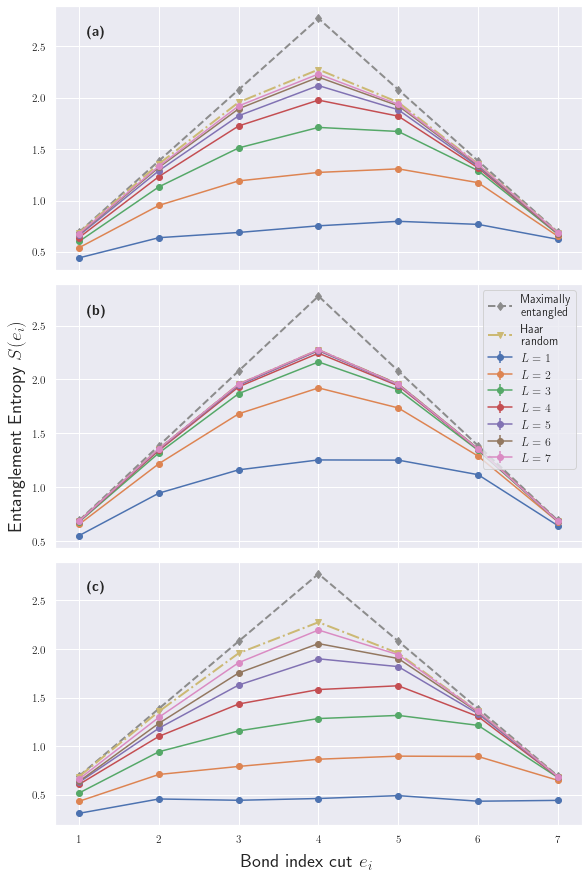

In [70]:
# Data to be plotted
to_plot = [ent_list, ent_list_c1, ent_list_c2]

def do_plot(dataplot, ax = None):
    for idx, data in enumerate(dataplot[:num_qubits-1]):
        ax.errorbar(range(1, num_qubits), data[0], yerr=0*data[1], color=cmap[idx], alpha=alphas[idx], label=f"$L={idx+1}$", marker='o')
    ax.plot(range(1, num_qubits), max_ent, ls='--', color=cmap[-3], lw=2, alpha=1, marker='d', label="Maximally\n entangled")
    ax.plot(range(1, num_qubits), ent_list[0, 2], ls='-.', color=cmap[-2], lw=2, alpha=1, marker='v', label="Haar\n random")

fig, ax = plt.subplots(len(to_plot),1, figsize = (8, 12), sharex = True)

# Set axis names and labels
labels = [f'$e_{i}$' for i in range(num_qubits)]
#ax[0].set_xticks(range(num_qubits))
#ax[1].set_xticks(range(num_qubits))
#ax[2].set_xticks(range(num_qubits))
#ax[2].set_xticklabels(labels=labels, fontsize=14)
#ax[2].set_xlabel("Bond index cut $e_i$", fontsize=16)
#fig.supylabel("Entanglement entropy $S$", fontsize=16)

fig.text(0.5, -0.01, 'Bond index cut $e_i$', ha='center', fontsize=19)
fig.text(-0.02, 0.5, 'Entanglement Entropy $S(e_i)$', va='center', rotation='vertical', fontsize=19)

# Define transparencies
alphas = np.ones(len(ent_list[:num_qubits-1])) #np.linspace(0.4, 1, len(ent_list[:num_qubits-1]))

# Plot data
do_plot(to_plot[0], ax[0])
do_plot(to_plot[1], ax[1])
do_plot(to_plot[2], ax[2])

# Add label to plot
ax[0].text(1.1, 2.6, r"$\textbf{(a)}$", fontsize=14)
ax[1].text(1.1, 2.6, r"$\textbf{(b)}$", fontsize=14)
ax[2].text(1.1, 2.6, r"$\textbf{(c)}$", fontsize=14)

# Fix legend position
ax[1].legend(loc=1, fontsize = 12)

plt.tight_layout()
#plt.savefig(f"{feature_map}_{var_ansatz}_{feature_map1}_{var_ansatz1}_{feature_map2}_{var_ansatz2}_final.pdf", format="pdf", bbox_inches='tight')

## MPS Simulation

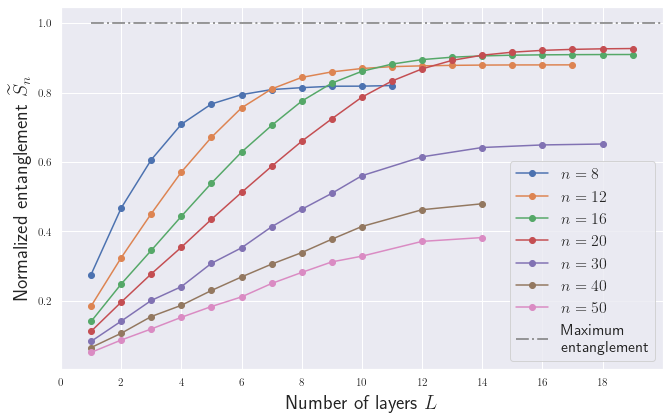

In [61]:
fig = plt.figure(figsize=(9.6, 6))
#plt.title(f"Abbas, alternate, linear entanglement")
plt.ylabel("Normalized entanglement $\\widetilde{S}_n$", fontsize=20, labelpad=7)
plt.xlabel("Number of layers $L$", fontsize=20, labelpad=7)
#num_qubs = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 30, 40, 50]
num_qubs = [ii for ii in range(8, 19, 4)] + [ii*10 for ii in range(2, 6)]
abbas = {nq:[np.loadtxt(f'data/ent_scaling/ent_scaling_High/alternate_abbas{nq}.npy'), 0] for nq in num_qubs}

alphas = np.ones(len(num_qubs))#np.linspace(0.2, 1, len(num_qubs))
for idx, qub in enumerate(num_qubs):
    data = abbas[qub][0]
    if qub < 30:
        num_reps = min(int( (len(data)-1 )/2 )+1, 20)
        reps = np.arange(1, num_reps)
    elif qub == 30:
        reps = np.append(np.arange(1, 11), [12, 14, 16, 18])
        num_reps = len(reps)+1
    elif qub == 40:
        reps = np.append(np.arange(1, 11), [12, 14])
        num_reps = len(reps)+1
    elif qub == 50:
        reps = np.append(np.arange(1, 11), [12, 14])
        num_reps = len(reps)+1
    else:
        num_reps = len(data)
        reps = np.arange(1, 11, 2)

    #plt.hlines(  data[0, :].max()/qub, 1, 20, ls="--", color=cmap(idx), lw = 2, alpha = 0.5)

    yval = data[1:num_reps, :].max(axis=1)/(qub/2)/np.log(2)
    plt.plot(reps,  yval, ls="-", marker="o", c=cmap[idx], label=f"$n = {qub}$", alpha= alphas[idx])

plt.hlines(  1, 1, 20, ls="-.", color='grey', lw = 2, alpha = 0.8, label='Maximum \n entanglement')

#plt.plot([],[], ls ='--', color = cmap(idx+1), label = "Haar-distributed")
#plt.hlines(  np.max(haar_mean/(num_qubs_haar-1)/np.log(2)), 1, 20, ls="--", color=cmap(idx+2), lw = 2, alpha = 0.5,
#    label='Maximum average Haar')

#plt.loglog()
#fig.legend(bbox_to_anchor=(1, 0.), loc="lower right", fontsize=16)
plt.legend(fontsize = 16)
plt.xlim(0, 20)
plt.xticks(np.arange(0, 20, 2))

plt.tight_layout()
#plt.savefig('normalized_entanglement_final.pdf', format='pdf', bbox_inches='tight')

## Alternate vs. Sequential data reuploading

In [27]:
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pl

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

cmap = sns.color_palette('deep', as_cmap=True)

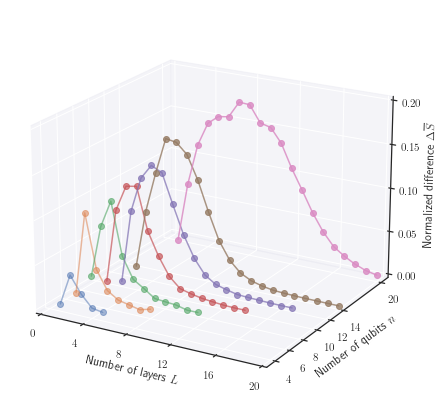

In [30]:
sns.set_style('white')

num_qubs = [4, 6, 8, 10, 12, 14, 20, 30, 40, 50]
abbas = {nq: [np.loadtxt(f'data/marcos_plot/alternate_abbas{nq}.npy'), np.loadtxt(f'data/marcos_plot/non_alternate_abbas{nq}.npy')] for nq in num_qubs}

fig = plt.figure(figsize=(9.6, 6))
ax = pl.subplot(projection='3d')

alphas = np.linspace(0.5, 1, len(num_qubs))
#colors = plt.cm.jet(np.linspace(0, 1, len(num_qubs)))

num_qubs = [4, 6, 8, 10, 12, 14, 20]
for idx, nq in enumerate(num_qubs):

    haar = np.max(abbas[nq][0][0, :])
    alternate = abbas[nq][0][1:, nq//2]
    non_alternate = abbas[nq][1][1:, nq//2]
    fc = 1
    if nq != 20:
        fc = 2
    len_data = min(len(alternate)//fc, len(non_alternate)//fc)
    len_data = min(len_data, 20) # fixing plot
    
    xs = np.arange(1, len_data+1)

    y = [nq]*len(xs)

    alternate = alternate[:len_data]
    non_alternate = non_alternate[:len_data]
    normalization = (alternate + non_alternate)/2
    z = (alternate - non_alternate)/normalization

    ax.plot(xs, y, z, ls="-", marker="o", c=cmap[idx], label=f'Num qub={nq}', alpha = alphas[idx])

ax.set_xlabel('Number of layers $L$', labelpad=3, fontsize = 12)
ax.set_zlabel('Normalized difference $\Delta \overline{S}$', labelpad=3, fontsize=12)
ax.set_ylabel('Number of qubits $n$', labelpad=3, fontsize=12)

#ax.set_xlabel('$L$', labelpad=3, fontsize = 14)
#ax.set_zlabel('$\Delta \overline{S}$', labelpad=3, fontsize=14)
#ax.set_ylabel('$n$', labelpad=3, fontsize=14)

ax.set_xlim(0, 20)
ax.set_zlim(0, 0.2)

ax.set_xticks(np.arange(0, 21, 4, dtype=int))
ax.set_yticks(num_qubs)
ax.set_zticks(np.linspace(0, 0.2, 5))

# Set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Grid color setup
ax.xaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle':'-', 'alpha':0.5, 'color':'w'})
ax.yaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle': '-', 'alpha': 0.5, 'color': 'w'})
ax.zaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle': '-', 'alpha': 0.5, 'color': 'w'})
#ax.grid(False)

# Pane color setup
ax.xaxis.pane.set_color('#EAEAF2')
ax.yaxis.pane.set_color('#EAEAF2')  # E6E6f2 # #EAEAF2
ax.zaxis.pane.set_color('#EAEAF2')

# Change view angle (standard is 30, -60)
ax.view_init(20, -60)

plt.tight_layout()
plt.savefig("entanglement_diff_3d_final.pdf", format='pdf', bbox_inches="tight")